In [1]:
import keras
import hrr as hrr
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# goal state:
bias = 1.0
reward = 1.0
gamma = 0.9
alpha = 0.01
lambd = 0.0
epsilon = 0.05
states = 20
episodes = 20000
non_reward = 0
hrr_size = 2048
non_goal_states = 0
actions = ['left', 'right']
colors = ['red', 'green']
gates = ['open', 'close']
sub_optimal_steps = []

In [3]:
memory = hrr.LTM(hrr_size, True)

In [4]:
# working memory
# this will choose the open/close action

def encode_gate(state, signal, w_m, gate_action):
    string = 'state_'  + str(state) + "*" + \
             'signal_' + str(signal) + "*" + \
             'w_m_' + str(w_m) + "*" + \
             'gate_action_' + str(gate_action)
    encoded = np.array([memory.encode(string)])
    return(encoded)

def q_gate(state, signal, w_m):
    max_value = 0 # -1000
#     for a in actions:
    for gate_action in gates:
        hrr = encode_gate(state, w_m, signal, gate_action)
        value = model_gate.predict(hrr)[0,0] + bias
        if value > max_value:
            max_value = value
            max_hrr = hrr
#             max_a = a
            max_gate = gate_action
    return  max_value, max_hrr, max_gate

model_gate = keras.models.Sequential()
model_gate.add(keras.layers.Dense(1,input_shape=[hrr_size],use_bias=False))
model_gate.compile(loss=keras.losses.mse,
                   optimizer=keras.optimizers.SGD(learning_rate=alpha),
                   metrics=['accuracy'])
model_gate.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2048      
Total params: 2,048
Trainable params: 2,048
Non-trainable params: 0
_________________________________________________________________


In [5]:
# working memory
# move l/r

def encode_move(state, signal, w_m, phyical_action):
    string = 'state_'  + str(state) + "*" + \
             'signal_' + str(signal) + "*" + \
             'w_m_' + str(w_m) + "*" + \
             'phyical_action_' + str(phyical_action)
    encoded = np.array([memory.encode(string)])
    return(encoded)

def q_move(state, signal, w_m):
    max_value = 0 # - 1000
    for phyical_action in actions:
#         for g in gates:
        hrr = encode_move(state, signal, w_m, phyical_action)
        value = model_move.predict(hrr)[0,0] + bias
        if value > max_value:
            max_value = value
            max_hrr = hrr
            max_action = phyical_action
#             gate = g
    return  max_value, max_hrr, max_action

model_move = keras.models.Sequential()
model_move.add(keras.layers.Dense(1,input_shape=[hrr_size],use_bias=False))
model_move.compile(loss=keras.losses.mse,
                   optimizer=keras.optimizers.SGD(learning_rate=alpha),
                   metrics=['accuracy'])
model_move.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 2048      
Total params: 2,048
Trainable params: 2,048
Non-trainable params: 0
_________________________________________________________________


In [6]:
# random mover 
def random_q_gate(state, signal, w_m):
#     a = np.random.choice(actions)
    gate = np.random.choice(gates)
#     hrr = encode_gate(state, signal, w_m, g)
    hrr = encode_gate(state, signal, w_m, gate)
    value = model_gate.predict(hrr)[0,0] + bias
    return value, hrr, gate

def random_q_move(state, signal, w_m):
    phyical_move = np.random.choice(actions)
#     g = np.random.choice(gates)
    hrr = encode_move(state, signal, w_m, phyical_move)
#     hrr_gate = encode_gate(state, signal, w_m, g)
    value = model_move.predict(hrr)[0,0] + bias
    return value, hrr, phyical_move

In [ ]:
for episode in range(episodes):
    
    # print every 1000 episodes for book keeping
    if (episode+1) % 1000 == 0:
        print("on ", episode+1)
        
    # lowering epsilon
    if episode == int(episodes/4):
        epsilon = epsilon/2
        print('epsilon changed to:', epsilon)
        
    if episode == int(episodes/4 * 1.6):
        epsilon = epsilon/2
        print('epsilon changed to:', epsilon)
        
    if episode == int(episodes/4 * 3.6):
        epsilon = 0 # epsilon/2
        print('epsilon changed to:', epsilon)
    
    # pick a state and a signal
    current_state = np.random.choice(states)
    current_signal = np.random.choice(colors)
    
    if current_signal == 'red':
        goal_state = 4
    else:
        goal_state = 12
    
    # counting optimal steps
    if goal_state < current_state:
        optimal_steps_1 = abs(goal_state - current_state)
        optimal_steps_2 = states - current_state + goal_state
    else:
        optimal_steps_1 = abs(goal_state - current_state)
        optimal_steps_2 = states - goal_state + current_state
    
    if optimal_steps_1 < optimal_steps_2:
        optimal_steps = optimal_steps_1
    else:
        optimal_steps = optimal_steps_2
    
    # clear out working memory
    current_w_m = ''
    
    for step in range(states):
        
        if current_state == goal_state:
            break
        
        if np.random.random() < epsilon:
            gate_value, \
            gate_hrr, \
            gate_action = random_q_gate(current_state, current_signal, current_w_m)
            current_value, \
            current_hrr, \
            current_action = random_q_move(current_state, current_signal, current_w_m)         
        else:
            gate_value, \
            gate_hrr, \
            gate_action = q_gate(current_state, current_signal, current_w_m)
            current_value, \
            current_hrr, \
            current_action = q_move(current_state, current_signal, current_w_m)
        
        previous_state = current_state
        
        previous_gate_value = gate_value
        previous_gate_hrr = gate_hrr
        previous_gate_action = gate_action
        
        previous_value = current_value
        previous_hrr = current_hrr
        previous_action = current_action
                
        # --------------------------------------------------
        
        if gate_action == 'open':
            current_w_m = current_signal
        
        current_signal = ''
        
        if (current_action == "left"):
            current_state = (current_state-1)%states
        else:
            current_state = (current_state+1)%states
            
        if current_state == goal_state:
            target = reward
        else:
            current_value, _, _ = q_move(current_state, current_signal, current_w_m)
            target = non_goal_states + gamma * current_value

        model_gate.fit(previous_gate_hrr, [target-bias], verbose=0)
        model_move.fit(previous_hrr, [target-bias], verbose=0)
        
    sub_optimal_steps.append(abs(step-optimal_steps))


on  1000
on  2000
on  3000
on  4000
on  5000
epsilon changed to: 0.025
on  6000
on  7000
on  8000
epsilon changed to: 0.0125
on  9000
on  10000
on  11000


In [ ]:
sub_optimal_average = []

for i in range(int(len(sub_optimal_steps)/100)):
    sub_optimal_average.append(sum(sub_optimal_steps[i*100:i*100+100])/len(sub_optimal_steps[i*100:i*100+100]))

In [ ]:
plt.plot(sub_optimal_average)
plt.grid(True)
plt.show()

In [ ]:
plt.plot(sub_optimal_average)
plt.grid(True)
plt.xlim(140,150)
plt.ylim(0, 2)
plt.show()

In [ ]:
sub_optimal_steps[-20:]

In [ ]:
print('size of dictionary ', len(memory.store))

open
close


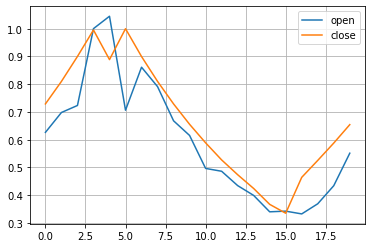

In [12]:
# all states, signal = red, w_m = '', gate_action open/close
data = []
for g in gates:
    print(g)
    data += [model_gate.predict(encode_gate(s, 'red', '', g))+bias for s in range(states)]
#     print(data)
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(gates)
plt.show()

In [13]:
# data

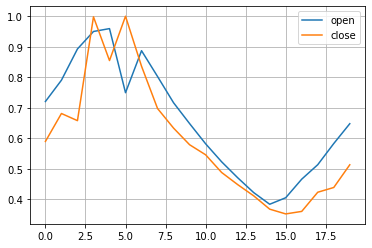

In [14]:
# all states, signal = '', w_m = 'red', gate_action open/close
data = []
for g in gates:
    data += [model_gate.predict(encode_gate(s, '', 'red', g))[0][0]+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(gates)
plt.show()

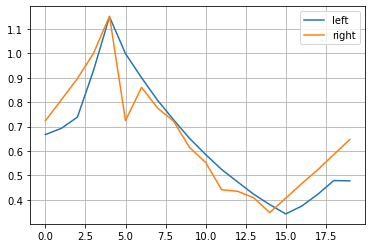

In [15]:
# all states, signal = red, w_m = '', phyical_actions l/r
data = []
for a in actions:
    data += [model_move.predict(encode_move(s, 'red', '', a))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(actions)
plt.show()

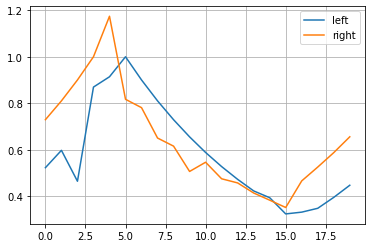

In [16]:
# all states, signal = red, w_m = '', phyical_actions l/r
data = []
for a in actions:
    data += [model_move.predict(encode_move(s, '', 'red', a))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(actions)
plt.show()

In [17]:
# greens

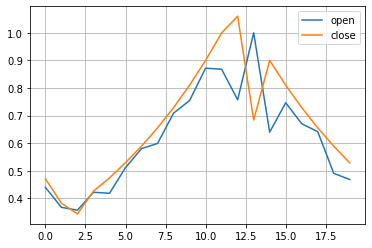

In [18]:
# all states, signal = green, w_m = '', gate_action open/close
data = []
for g in gates:
    data += [model_gate.predict(encode_gate(s, 'green', '', g))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(gates)
plt.show()

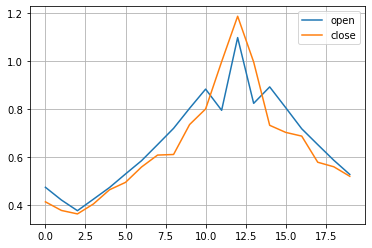

In [19]:
# all states, signal green, w_m = '', gate_action open/close
data = []
for g in gates:
    data += [model_gate.predict(encode_gate(s, '', 'green', g))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(gates)
plt.show()

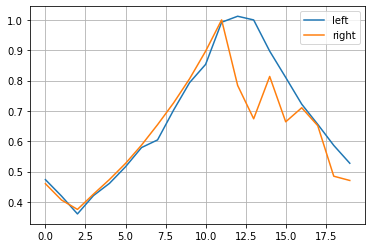

In [20]:
# all states, signal = green, w_m = '', phyical_actions l/r
data = []
for a in actions:
    data += [model_move.predict(encode_move(s, 'green', '', a))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

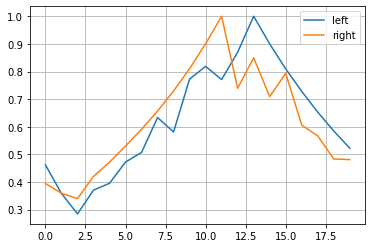

In [26]:
# all states, signal = green, w_m = '', phyical_actions l/r
data = []
for a in actions:
    data += [model_move.predict(encode_move(s, '', 'green', a))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [12]:
# def encode(s, a, g, signal, w_m):
#     string = 'action_' + str(a) + "*" + \
#              'gate_'   + str(g) + "*" + \
#              'state_'  + str(s) + "*" + \
#              'signal_' + str(signal) + "*" + \
#              'w_m_' + str(w_m) 
#     encoded = np.array([memory.encode(string)])
#     return(encoded)

# def q(state, signal, w_m):
#     max_value = 0
#     for a in actions:
#         for g in gates:
#             hrr = encode(state, a, g, signal, w_m)
#             value = model.predict(hrr)[0,0] + bias
#             if value > max_value:
#                 max_value = value
#                 max_hrr = hrr
#                 max_a = a
#                 gate = g
#     return  max_value, max_hrr, max_a, gate

# model = keras.models.Sequential()
# model.add(keras.layers.Dense(1,input_shape=[hrr_size],use_bias=False))
# model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.SGD(learning_rate=alpha))
# model.summary()

In [13]:
# s, a, g, signal, w_m

In [14]:
# red
# actions = ['l', 'r']
# colors = ['red', 'green']
# gates = ['open', 'close']
# encode_gate(state, signal, w_m, gate_action)
# encode_move(state, signal, w_m, phyical_action)